

# How to Segment Videos with Segment Anything 3 (SAM3)

---


SAM 3 (Segment Anything Model 3) extends the SAM series by moving from segmenting individual objects to understanding and segmenting all instances of a concept in images and videos. It introduces Promptable Concept Segmentation (PCS), where users specify a concept through short noun phrases like “striped cat” or by providing visual exemplars. The model detects, segments, and tracks every matching object, preserving identities across frames.


## Environment setup

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM 3 checkpoints.

- Request access to the SAM 3 checkpoints on the official Hugging Face [repo](https://huggingface.co/facebook/sam3).
- Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
- In Colab, go to the left pane and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.



In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu Feb  5 16:14:53 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [4]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

Cloning into 'sam3'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 906 (delta 0), reused 0 (delta 0), pack-reused 904 (from 2)
Receiving objects: 100% (906/906), 59.45 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (177/177), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 M

/content


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 9.5 MB/s eta 0:00:00


In [6]:
!pip uninstall -y cc_torch; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/cc_torch
!pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/torch_generic_nms

  Cloning https://github.com/ronghanghu/cc_torch to /tmp/pip-req-build-h_95knv6
  Running command git clone --filter=blob:none --quiet https://github.com/ronghanghu/cc_torch /tmp/pip-req-build-h_95knv6
  Resolved https://github.com/ronghanghu/cc_torch to commit 446e9360ed10d3c8d03925ccb5f220ccb62009de
  Preparing metadata (setup.py) ... done
  Created wheel for cc_torch: filename=cc_torch-0.2-cp312-cp312-linux_x86_64.whl size=322908 sha256=d0e43e5e5040fc4c4702c9136a46bd32a2d5e89062625788abd2e25b2355e0be
  Stored in directory: /tmp/pip-ephem-wheel-cache-bjj1wyiw/wheels/ec/00/d2/dd6e3f726591979dbc35c61d4feb785f48529310b422937236
Successfully built cc_torch
  Cloning https://github.com/ronghanghu/torch_generic_nms to /tmp/pip-req-build-wsh27ccl
  Running command git clone --filter=blob:none --quiet https://github.com/ronghanghu/torch_generic_nms /tmp/pip-req-build-wsh27ccl
  Resolved https://github.com/ronghanghu/torch_generic_nms to commit fcf02b41ea9b37988b244ef80583af17baa4a7f0
  Prepa

### Download example data

Downloads example videos. You can use these or replace them with your own videos.

In [4]:
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 55.7MB/s]


In [5]:
!ffmpeg -y -i "/content/121364_0.mp4" -t 5 -c:v libx264 -preset fast -crf 23 -c:a aac -b:a 128k "/content/out_5s.mp4"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [4]:
VIDEO_PATH = "/content/drive/MyDrive/SportsIn/videos"

In [6]:
!ls -la

total 19380
drwxr-xr-x 1 root root     4096 Feb  5 14:39 .
drwxr-xr-x 1 root root     4096 Feb  5 14:33 ..
-rw-r--r-- 1 root root 17245114 Jul 25  2024 121364_0.mp4
drwxr-xr-x 4 root root     4096 Dec  9 14:41 .config
drwx------ 5 root root     4096 Feb  5 14:35 drive
-rw-r--r-- 1 root root  2569341 Feb  5 14:39 out_5s.mp4
drwxr-xr-x 9 root root     4096 Feb  5 14:34 sam3
drwxr-xr-x 1 root root     4096 Dec  9 14:42 sample_data


<font color="red">⚠️ Restart session.</font>

## Imports

In [3]:
import cv2
import torch

import numpy as np
import supervision as sv

from pathlib import Path
from PIL import Image
from typing import Optional
from IPython.display import Video

from sam3.model_builder import build_sam3_video_predictor

In [6]:
HOME = Path.cwd()
print("HOME:", HOME)

HOME: /content


## Promptable Concept Segmentation (PCS)

### Load SAM3 model

In [4]:
# use all available GPUs on the machine
# DEVICES = range(torch.cuda.device_count())

# # use only a single GPU
DEVICES = [torch.cuda.current_device()]

## produced errore : this was because of additional space added to the tokes!!
---------------------------------------------------------------------------
HTTPStatusError                           Traceback (most recent call last)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py in hf_raise_for_status(response, endpoint_name)
    656     try:
--> 657         response.raise_for_status()
    658     except httpx.HTTPStatusError as e:

15 frames
HTTPStatusError: Client error '401 Unauthorized' for url 'https://huggingface.co/facebook/sam3/resolve/main/config.json'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/401

The above exception was the direct cause of the following exception:

GatedRepoError                            Traceback (most recent call last)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py in hf_raise_for_status(response, endpoint_name)
    675                 f"{response.status_code} Client Error." + "\n\n" + f"Cannot access gated repo for url {response.url}."
    676             )
--> 677             raise _format(GatedRepoError, message, response) from e
    678
    679         elif error_message == "Access to this resource is disabled.":

GatedRepoError: 401 Client Error. (Request ID: Root=1-6982643a-3338195010fb49c60309d2c1;80dca362-e1d9-4e52-9eec-6bf7391c7b3b)

Cannot access gated repo for url https://huggingface.co/facebook/sam3/resolve/main/config.json.
Access to model facebook/sam3 is restricted. You must have access to it and be authenticated to access it. Please log in.

In [5]:
predictor = build_sam3_video_predictor(bpe_path="/content/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz", gpus_to_use=DEVICES)

INFO 2026-02-05 16:31:32,806 30495 sam3_video_predictor.py: 300: using the following GPU IDs: [0]
INFO 2026-02-05 16:31:32,808 30495 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-05 16:31:32,809 30495 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2026-02-05 16:31:42,909 30495 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-05 16:31:59,626 30495 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-05 16:31:59,627 30495 sam3_video_predictor.py: 331: 


	*** DONE loading model on all ranks ***




### Process the video

SAM 3 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [6]:
HOME = Path.cwd()
VIDEO_NAME = "out_5s.mp4" # <--- CHECK THIS NAME
SOURCE_VIDEO = HOME / VIDEO_NAME
SOURCE_FRAMES = HOME / SOURCE_VIDEO.stem

SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

In [12]:
!ffmpeg -i {SOURCE_VIDEO} -q:v 2 -start_number 0 {SOURCE_FRAMES}/'%05d.jpg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [7]:
def load_frame(directory: str, index: int):
    """
    Loads a frame with a specific index from a directory where frames are named
    using the pattern '%05d.jpg' (e.g., 00000.jpg, 00001.jpg, 00002.jpg).

    Args:
        directory (str): Path to the directory containing image frames.
        index (int): Frame index (0-based).

    Returns:
        numpy.ndarray: Loaded frame in BGR format.

    Raises:
        FileNotFoundError: If the frame does not exist or cannot be read.
    """
    directory_path = Path(directory)
    frame_path = directory_path / f"{index:05d}.jpg"

    if not frame_path.exists():
        raise FileNotFoundError(f"Frame not found: {frame_path}")

    frame = cv2.imread(str(frame_path))
    if frame is None:
        raise FileNotFoundError(f"Failed to load frame: {frame_path}")

    return frame

### Opening video inference session


SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an inference session on this video. During initialization, it loads all the JPEG frames in the video directory and stores their features in the session state.

In [8]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=SOURCE_VIDEO.as_posix(),
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 125/125 [00:01<00:00, 69.60it/s]


In [34]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

### Adding a box prompt

Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

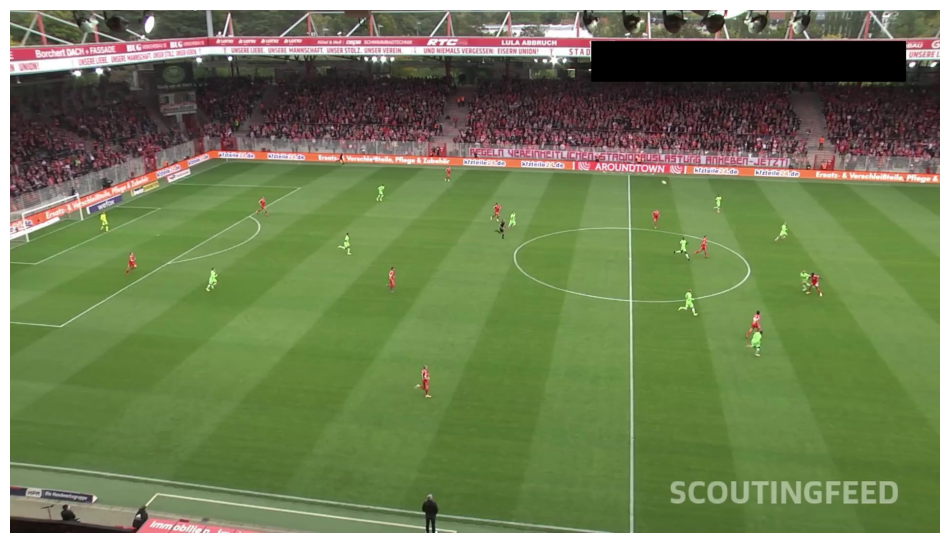

In [13]:
frame_idx = 0
frame = load_frame(SOURCE_FRAMES, frame_idx)

sv.plot_image(frame)

## new cell to box prompot

In [10]:
# 1. Run this to get a widget to draw your box
#import base64 # will ignoer
from jupyter_bbox_widget import BBoxWidget
frame_idx = 0

def encode_image(filepath):
    with open(filepath, "rb") as f:
        return f.read()
try:
        widget = BBoxWidget()
        widget.image_bytes = encode_image(str(SOURCE_FRAMES / f"{frame_idx:05d}.jpg"))
        #widget.classes = ["Target"]

        print(f"Loaded: {str(SOURCE_FRAMES / f"{frame_idx:05d}.jpg")}")
        print("Draw your box on the image below:")
        display(widget)
except Exception as e:
        print(f"Widget Error: {e}")

Loaded: /content/out_5s/00000.jpg
Draw your box on the image below:


In [29]:
widget.bboxes[0]

{'x': 767, 'y': 525, 'width': 44, 'height': 69, 'label': ''}

In [30]:
BOX_COORDINATES = [
                   widget.bboxes[0]['x'],
                   widget.bboxes[0]['y'],
                   widget.bboxes[0]['width'],
                   widget.bboxes[0]['height']
                    ]
print(" coordinates:", BOX_COORDINATES)

 coordinates: [767, 525, 44, 69]


In [20]:
import inspect

# Get the function that handles the dictionary
method = predictor.handle_request

# Print the code logic
print(inspect.getsource(method))

    @torch.inference_mode()
    def handle_request(self, request):
        """Dispatch a request based on its type."""
        if self.has_shutdown:
            raise RuntimeError(
                "cannot handle request after the predictor has shutdown; please create a new predictor"
            )

        # when starting a session, we need to create a session id before dispatching
        # the request to the workers
        if request["type"] == "start_session" and request.get("session_id") is None:
            request["session_id"] = str(uuid.uuid4())
        # dispatch the request to all worker processes
        if self.world_size > 1 and self.rank == 0:
            for rank in range(1, self.world_size):
                self.command_queues[rank].put((request, False))

        response = super().handle_request(request)

        if self.world_size > 1:
            torch.distributed.barrier()  # wait for all ranks to finish
        return response



In [21]:
import inspect

# Get the PARENT class of the predictor
parent_class = predictor.__class__.__bases__[0]

# Print the source code of the parent's handle_request
print(f" Inspecting Parent Class: {parent_class.__name__}")
try:
    print(inspect.getsource(parent_class.handle_request))
except Exception as e:
    print("Could not find source. Trying direct method inspect...")
    print(inspect.getsource(predictor.handle_request))

 Inspecting Parent Class: Sam3VideoPredictor
    @torch.inference_mode()
    def handle_request(self, request):
        """Dispatch a request based on its type."""
        request_type = request["type"]
        if request_type == "start_session":
            return self.start_session(
                resource_path=request["resource_path"],
                session_id=request.get("session_id", None),
            )
        elif request_type == "add_prompt":
            return self.add_prompt(
                session_id=request["session_id"],
                frame_idx=request["frame_index"],
                text=request.get("text", None),
                points=request.get("points", None),
                point_labels=request.get("point_labels", None),
                bounding_boxes=request.get("bounding_boxes", None),
                bounding_box_labels=request.get("bounding_box_labels", None),
                obj_id=request.get("obj_id", None),
            )
        elif request_type == 

In [17]:
from PIL import Image

# 1. Get the Image Size (Width, Height)
# We need to open the actual image file to know how big it is
image_path = SOURCE_FRAMES / f"{frame_idx:05d}.jpg"
with Image.open(image_path) as img:
    img_w, img_h = img.size

print(f" Image Size: {img_w}x{img_h}")

 Image Size: 1920x1080


In [32]:
normalized_box=[
    BOX_COORDINATES[0]/img_w,
    BOX_COORDINATES[1]/img_h,
    BOX_COORDINATES[2]/img_w,
    BOX_COORDINATES[3]/img_h
]
normalized_box


[0.39947916666666666,
 0.4861111111111111,
 0.022916666666666665,
 0.06388888888888888]

In [35]:
# Give this specific object a unique ID (e.g., 1)
OBJECT_ID = 0

# We set text to None so the annotator doesn't crash later
text = None

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        bounding_boxes=[normalized_box],
        bounding_box_labels=[1],
        obj_id=OBJECT_ID
    )
)

result = response["outputs"]
print(f" Object {OBJECT_ID} added with box {BOX_COORDINATES}")
print(result)

 Object 0 added with box [767, 525, 44, 69]
{'out_obj_ids': array([0, 1, 2, 3, 4, 5, 6]), 'out_probs': array([0.518797  , 0.8202247 , 0.69082123, 0.5241636 , 0.8083832 ,
       0.5345455 , 0.5241636 ], dtype=float32), 'out_boxes_xywh': array([[0.79062504, 0.5740741 , 0.01927083, 0.08888888],
       [0.40208337, 0.4888889 , 0.01666667, 0.06111111],
       [0.5161459 , 0.36759257, 0.028125  , 0.0712963 ],
       [0.85      , 0.49814814, 0.0234375 , 0.05      ],
       [0.4322917 , 0.67685187, 0.02239583, 0.06759259],
       [0.259375  , 0.35555553, 0.01875   , 0.03981481],
       [0.12291668, 0.46296296, 0.01354167, 0.04629629]], dtype=float32), 'out_binary_masks': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, 

In [26]:
print(result.keys())

dict_keys(['out_obj_ids', 'out_probs', 'out_boxes_xywh', 'out_binary_masks', 'frame_stats'])


In [27]:
print(result.items())

dict_items([('out_obj_ids', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])), ('out_probs', array([0.69953054, 0.7655678 , 0.6483516 , 0.82795703, 0.80487806,
       0.70642203, 0.69953054, 0.87878793, 0.6717949 , 0.6683938 ,
       0.80487806, 0.60975605, 0.67512685, 0.7852349 , 0.8241758 ,
       0.73443985, 0.67512685, 0.5816993 , 0.78877884, 0.69082123,
       0.71929824, 0.664042  ], dtype=float32)), ('out_boxes_xywh', array([[0.8213542 , 0.4074074 , 0.01458333, 0.03796296],
       [0.51718754, 0.3685185 , 0.01041667, 0.03611111],
       [0.52239585, 0.4       , 0.00989583, 0.03796296],
       [0.40625003, 0.49074075, 0.00833333, 0.05092593],
       [0.79114586, 0.5740741 , 0.0171875 , 0.05833333],
       [0.09635417, 0.38425925, 0.00989583, 0.04259259],
       [0.8546876 , 0.50277776, 0.01822917, 0.04537037],
       [0.4354167 , 0.67870367, 0.0171875 , 0.06296296],
       [0.39375   , 0.3333333 , 0.009375  , 0.03333333],
    

In [20]:
import numpy as np

def get_target_data(result, box):

    ids = result['out_obj_ids'] # result.get("out_obj_ids", np.array([]))
    boxes = result['out_boxes_xywh']
    masks = result['out_binary_masks']
    probs = result['out_probs']

    # 1. Calculate the Euclidean distance between target box [x,y,w,h]
    # and all  detected boxes
    # We focus on the first two elements (x, y) which are the centers/top-left
    differences = boxes[:, :2] - np.array(box[:2])
    distances = np.linalg.norm(differences, axis=1)

    # 2. Find the index of the box that is closest to yours
    best_idx = np.argmin(distances)

    # 3. Pull the specific data for just that player
    target_id = ids[best_idx]
    target_box = boxes[best_idx]
    target_mask = masks[best_idx]
    target_prob = probs[best_idx]

    return target_id, target_box, target_mask , target_prob

# Usage:
# target_box = [0.7140625, 0.530555, 0.029166, 0.058333]
target_id, target_box, target_mask , target_prob = get_target_data(result, normalized_box)

print(f"Target found at index {target_id} with box {target_box}")

Target found at index 0 with box [0.4041667  0.4888889  0.01197917 0.05648148]


### Visualize results

In [34]:
# def from_sam(result: dict) -> sv.Detections:
#     return sv.Detections(
#         xyxy=sv.mask_to_xyxy(result["out_binary_masks"]),
#         mask=result["out_binary_masks"],
#         confidence=result["out_probs"],
#         tracker_id=result["out_obj_ids"]
#     )

In [32]:
# def from_sam(result: dict) -> sv.Detections:
#     return sv.Detections(
#         xyxy=sv.mask_to_xyxy([target_mask]),
#         mask=[target_mask],
#         confidence=[target_prob],
#         tracker_id=[target_id]
#     )

In [21]:
def from_sam(result: dict, target_id: int) -> sv.Detections:
    # 1. Get the lists for this specific frame
    obj_ids = result.get("out_obj_ids", np.array([]))
    masks = result.get("out_binary_masks", [])
    probs = result.get("out_probs", [])

    # 2. Find the position of OUR player (target_id) in this frame's list
    # The player might be at index 15 in frame 1, but index 12 in frame 100
    match_indices = np.where(obj_ids == target_id)[0]

    if match_indices.size > 0:
        idx = match_indices[0]
        m = masks[idx]
        p = probs[idx]

        # 3. Wrap it in a supervision Detections object
        return sv.Detections(
            xyxy=sv.mask_to_xyxy(np.array([m])),
            mask=np.array([m]),
            confidence=np.array([p]),
            tracker_id=np.array([target_id])
        )

    # Return empty detections if the player is occluded or out of frame
    return sv.Detections.empty()

In [22]:
COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

def annotate(image: np.ndarray, detections: sv.Detections, text = None) -> np.ndarray:
    h, w, _ = image.shape
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.TRACK,
        opacity=0.6
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)

    if text:
        label_annotator = sv.LabelAnnotator(
            color=COLOR,
            color_lookup=sv.ColorLookup.TRACK,
            text_scale=text_scale,
            text_color=sv.Color.BLACK,
            text_position=sv.Position.TOP_CENTER,
            text_offset=(0, -30)
        )
        labels = [
            f"#{tracker_id} {text}"
            for tracker_id in detections.tracker_id
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

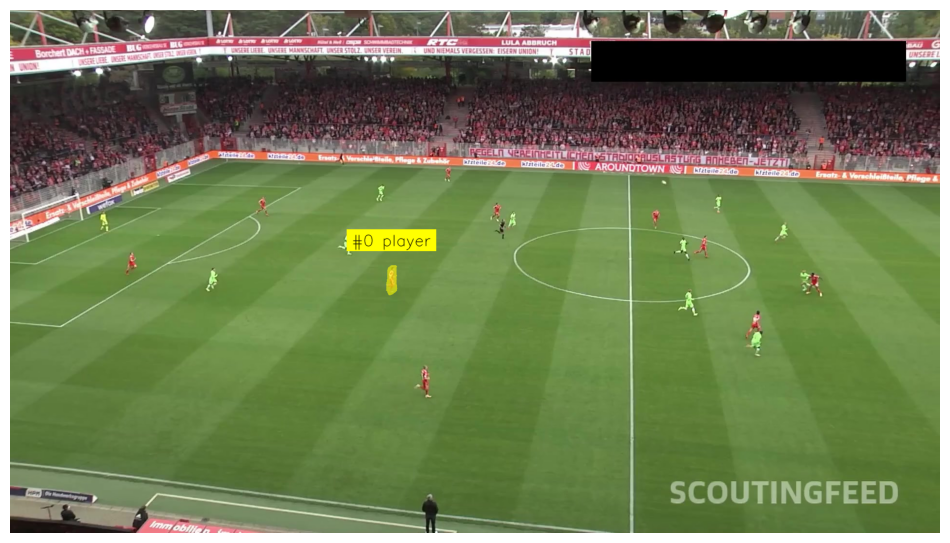

In [23]:
detections = from_sam(result,target_id)


annotated_frame = annotate(frame, detections, text="player")

sv.plot_image(annotated_frame)


## Update 1 to solve the track obj id

In [91]:
detections = from_sam(result)
print(detections)

Detections(xyxy=array([[1577,  439, 1605,  482],
       [ 837,  734,  869,  801],
       [ 992,  398, 1013,  437],
       [1003,  432, 1022,  473],
       [1518,  620, 1552,  682],
       [ 185,  415,  204,  461],
       [1641,  543, 1676,  592],
       [ 756,  359,  774,  397],
       [1026,  417, 1043,  453],
       [ 503,  386,  533,  426],
       [ 781,  530,  795,  585],
       [1518,  663, 1553,  716],
       [1414,  467, 1441,  513],
       [ 238,  501,  261,  548],
       [ 897,  325,  910,  358],
       [1376,  576, 1420,  633],
       [ 677,  297,  690,  321],
       [1323,  412, 1341,  453],
       [ 403,  532,  429,  582],
       [1454,  381, 1470,  420],
       [1370,  468, 1403,  518],
       [ 676,  460,  703,  507]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [F

In [40]:
if target_id < len(detections.xyxy):
    filtered = sv.Detections(
        xyxy = np.asarray(detections.xyxy)[[target_id]],
        mask = np.asarray(detections.mask)[[target_id]],
        confidence = np.asarray(detections.confidence)[[target_id]],
        tracker_id = np.array([int(OBJECT_ID)]) # Set this to your desired ID (e.g., 1)
    )

    # 4. Annotate only that specific detection
    # This will now ignore the other 21 players
    annotated_frame = annotate(frame, filtered, text="player")
    sv.plot_image(annotated_frame)
else:
    print(f"Index {target_id} is out of bounds for the detected objects.")

Index 3 is out of bounds for the detected objects.


### Propagate in video

In [46]:
def propagate_in_video(predictor, session_id):
    frame_outputs = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        frame_outputs[response["frame_index"]] = response["outputs"]

    return frame_outputs

In [ ]:
target_id, _, _, _ = get_target_data(result, normalized_box)
all_ids = result.get("out_obj_ids", [])

# remove every id not in target
for obj_id in all_ids:
    if obj_id != target_id:
        predictor.handle_request(
            request=dict(
                type="remove_object",
                session_id=session_id,
                obj_id=int(obj_id)
            )
        )


In [ ]:
frame_outputs = propagate_in_video(predictor=predictor, session_id=session_id)

In [ ]:
TARGET_VIDEO = HOME / f"{SOURCE_VIDEO.stem}-result{SOURCE_VIDEO.suffix}"
TARGET_VIDEO_COMPRESSED = HOME / f"{TARGET_VIDEO.stem}-compressed{TARGET_VIDEO.suffix}"

target_id, _, _, _ = get_target_data(result, normalized_box)
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    annotated_frame = frame.copy()
    output = frame_outputs[index]
    detections = from_sam(output , target_id)
    return annotate(frame, detections, text="player")



In [ ]:
sv.process_video(
    source_path=SOURCE_VIDEO,
    target_path=TARGET_VIDEO,
    callback=callback,
    target_fps=5
)


In [ ]:
!ffmpeg -y -loglevel error -i {TARGET_VIDEO} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED, embed=True, width=1080)

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>